# Text Classification

In this notebook, we will work with text data from newsgroup postings on a variety of topics. We will train classifiers to distinguish between the topics based on the text of the posts. We will represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse, i.e. only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

For those with some experience with NLP know the NTLK library provides a number of useful features. We will not use it here since the idea is to demonstrate the concepts and not necessarily to acheive a high accuracy rate.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. 

We've taken a subset of categories to keep to allow classifiers execute quickly. You can change the categories attribute in fetch_20newsgroups function to get all categories.

In [2]:
categories = ['misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

# setting up the train, test and dev set variables.
num_test = len(newsgroups_test.target)
num_dev = int(num_test/2)

test_data, test_labels = newsgroups_test.data[(num_dev):], newsgroups_test.target[(num_dev):]
dev_data, dev_labels = newsgroups_test.data[:num_dev], newsgroups_test.target[:num_dev]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

### Some basic EDA

#### Checking sizes of data sets and label names

In [29]:
print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (3569,)
test label shape: (1188,)
dev label shape: (1188,)
labels names: ['misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt']


#### Let us see what the data looks like For each of the first 5 training examples, print the text of the message along with the label.

In [30]:
def examples(num_examples=5):
    
    for i in range(num_examples):
        print("Text of type : ", newsgroups_train.target_names[train_labels[i]])
        print("Text :")
        print(train_data[i])
        print("------------------------------------------------------------------")
        print()
        print()
          

examples(5)

Text of type :  rec.autos
Text :
I'd like to converse with anyone who has purchased a 1993 Honda
Civic about their experience.  I'm new to the car buying game
and would like to know what price I can expect to pay for a sedan
after bargaining.

Thanks in advance,
------------------------------------------------------------------


Text of type :  misc.forsale
Text :
This drive is less than one year old.  The cartridges have all been bought
since then.  All is in excellent condition and still under warranty.
Due to a change in system use, I now need a large, contiguous drive.

Offer includes:
	SyDos 44i internal drive
	SCSI adapter card and cables
	All original documentation
	Software
	All original packaging
	8 cartridges totalling over 350Mb (no bad sectors or defects)

The installation was a breeze on my 386 clone.

I will trade for something near 300Mb IDE, or sell for $450.
I will also consider trading for 4 4Mx9 30 pin SIMMs at 70ns.
-------------------------------------------------

### Exploring CountVectorizer

CountVectorizer turns the raw training text into feature vectors. The fit_transform functionmakes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, we will write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? 

b. What are the 0th and last feature strings (in alphabetical order)?

c. Ability to take custom vocabulary. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Check the average number of non-zero features per example with custom vocabulary?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram **character** features. Check the size vocabulary now.

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? 

In [3]:
def exploreCountVectorizer():

    def printUtil(X):
        sizeVocab = X.shape[1]
        aveNonZero = np.average(np.sum(X, axis=1))
        fracNonZero = X.nnz/(X.shape[0]*X.shape[1])
        print("-------")
        print("Size of Vocabulary : ", sizeVocab)
        print("Average non zero features per example : ", round(aveNonZero, 2))
        print("Fraction of non zero entries ", round(fracNonZero, 6))
        print()
        print()  

    
### Base case
    countVector = CountVectorizer()
    X = countVector.fit_transform(train_data)
    print("a. Base case")
    printUtil(X)

### feature names
    featureNames = countVector.get_feature_names()
    print("b. feature names")
    print("-------")
    print("First few features are '"+ str(featureNames[:5]) + "' and last few features are '" + str(featureNames[-5:]) + "'")
    print()
    print()

### custom vocabulary
    myVocab = ['sale', 'car', 'motorcycle', 'baseball', 'hockey', 'science']
    countVector = CountVectorizer(vocabulary=myVocab)
    X = countVector.fit_transform(train_data)
    print("c. Custom vocabulary")
    printUtil(X)   
    
### Character features and n-grams
    ngram_range = (2,2)
    countVector = CountVectorizer(ngram_range = ngram_range, analyzer='char')
    X = countVector.fit_transform(train_data)
    print("d. Character feature with ngram = 2")
    printUtil(X)   

    ngram_range = (3,3)
    countVector = CountVectorizer(ngram_range = ngram_range, analyzer='char')
    X = countVector.fit_transform(train_data)
    print("d. Character feature with ngram = 3")
    printUtil(X) 

### exclude infrequent words
    countVector = CountVectorizer(min_df=10)
    X = countVector.fit_transform(train_data)
    print("e. Exclude infrequent words")
    printUtil(X)   

### vocabulary in training and dev will be different
    countVector = CountVectorizer()
    countVector.fit_transform(train_data)
    trainFeatures = countVector.get_feature_names()
    countVector.fit_transform(dev_data)
    devFeatures = countVector.get_feature_names()
    missingInDev = len(set(trainFeatures).difference(set(devFeatures)))
    
    print("f. Comparing vocabulary of training and dev data sets:")
    print("-------")
    print("Training data has", missingInDev, "features that are not in Dev")
    print("Fraction of features in training data missing in dev are: ", round(missingInDev/len(trainFeatures), 3))


exploreCountVectorizer()

a. Base case
-------
Size of Vocabulary :  32403
Average non zero features per example :  145.91
Fraction of non zero entries  0.00259


b. feature names
-------
First few features are '['00', '000', '0000', '00000000', '0000000004']' and last few features are '['zz', 'zzcrm', 'zzi776', 'zzzzzz', 'zzzzzzt']'


c. Custom vocabulary
-------
Size of Vocabulary :  6
Average non zero features per example :  0.45
Fraction of non zero entries  0.041702


d. Character feature with ngram = 2
-------
Size of Vocabulary :  4410
Average non zero features per example :  890.12
Fraction of non zero entries  0.045992


d. Character feature with ngram = 3
-------
Size of Vocabulary :  45286
Average non zero features per example :  889.15
Fraction of non zero entries  0.009426


e. Exclude infrequent words
-------
Size of Vocabulary :  4193
Average non zero features per example :  124.17
Fraction of non zero entries  0.016003


f. Comparing vocabulary of training and dev data sets:
-------
Training dat

### Basic Classifiers

Let us start with:

* KNN
* Naive Bayes
* Logistic regression


In [4]:
def basicClassifiers():


    countVector = CountVectorizer()
    X = countVector.fit_transform(train_data)
    countVector1 = CountVectorizer(vocabulary=countVector.get_feature_names())
    XDev = countVector1.fit_transform(dev_data)
    
    def modelPerformance(classifier, model):
        y_predict = classifier.predict(XDev)
        f1=metrics.f1_score(dev_labels, y_predict, average='micro')
        key = [*classifier.best_params_][0]
        print(model, ':')
        print('Best', model, 'fit is found when',key, '=', classifier.best_params_.get(key))
        print('F1 with dev data of this model is ', round(f1, 4))
        print()
    
# Nearest Neighbors
    classifier = KNeighborsClassifier()
    ks = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
    grid = GridSearchCV(classifier, ks, cv=5, scoring='f1_micro', n_jobs=-1)
    trained_classifier = grid.fit(X, train_labels)
    
    modelPerformance(trained_classifier, 'K Nearest Neighbors')
    
# Naive Bayes
    classifier = MultinomialNB()
    alphas = {'alpha': [ 0.01, .011, .012, .013, .014, .015, .016, .017, .018, .019, .1]}
    grid = GridSearchCV(classifier, alphas, cv=5, scoring='f1_micro', n_jobs=-1)
    trained_classifier = grid.fit(X, train_labels)

    modelPerformance(trained_classifier, 'Multinominal Naive Bayes')
    
# Logistic
    classifier = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial')
    Cs = {'C': [0.01, 0.1, .25, 0.5, .75]}
    grid = GridSearchCV(classifier, Cs, cv=5, scoring='f1_micro', n_jobs=-1)
    trained_classifier = grid.fit(X, train_labels)

    modelPerformance(trained_classifier, 'Logistic Regression')

basicClassifiers()
    

K Nearest Neighbors :
Best K Nearest Neighbors fit is found when n_neighbors = 5
F1 with dev data of this model is  0.3754

Multinominal Naive Bayes :
Best Multinominal Naive Bayes fit is found when alpha = 0.014
F1 with dev data of this model is  0.8266

Logistic Regression :
Best Logistic Regression fit is found when C = 0.1
F1 with dev data of this model is  0.7668



**Key takeaways**

1. Nearest neighbors performs poorly as compared to other models. Consider a model with a single word vocabulary and the trained model expecting 2 occurrences for a certain class. For the model, test samples containing zero or four occurrences are equally far. However, we intuitively know that the one with 4 occurrences is more likely to be close to the class compared to the text with zero occurrences. In fact sample texts with more than 4 occurrences will actually be further away from trained model as compared to text with zero occurrences.

2. Naive Bayes vs Logistic regression: In this case Naive Bayes performs better than logistic regression. However, logistic regression is almost always better than a generative model such as Naive Bayes when large amount of data is available. So, with smaller data sets a generative model might give a good performance but as more and more training data is available, Logistic regression should take over. More on this topic in paper from Andrew Ng and Michael Jordan (https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf)

### L2 regularization 
Logistic regression estimates a weight vector for each class, which can be accessed with the coef\_ attribute. Recall that L2 regularization attempts to minimize the sum of square coefficients. Here we will see how the sum of square coefficients vary with strength of regularization.

In [35]:
def l2Regularization():
    
    countVector = CountVectorizer()
    X = countVector.fit_transform(train_data)
    countVector1 = CountVectorizer(vocabulary=countVector.get_feature_names())
    XDev = countVector1.fit_transform(dev_data)
    
    listC = [0.01, 0.1, .25, 0.5, .75]
    table = np.empty((0,0))
    for C in listC:
        classifier = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial', C=C)
        trained_classifier = classifier.fit(X, train_labels)
        table = np.append(table, C)
        for i in trained_classifier.classes_:
            sumSqWt = np.matmul(trained_classifier.coef_[i], np.transpose(trained_classifier.coef_[i]))
            table = np.append(table, round(sumSqWt, 3))
    np.set_printoptions(suppress=True)
    print('Demonstration of l2 regularization')
    print(table.reshape((len(listC),-1)))

l2Regularization()

Demonstration of l2 regularization
[[  0.01    2.515   2.39    2.476   2.45    2.554   2.314]
 [  0.1    18.118  20.909  22.577  21.154  19.813  17.24 ]
 [  0.25   35.365  42.818  47.391  43.632  39.79   33.646]
 [  0.5    55.556  69.182  78.381  71.216  64.119  52.604]
 [  0.75   70.745  89.431 102.648  92.662  82.976  66.664]]


**Key takeaways**   
This demonstrates effect of regularization on size of wieghts. L2 regularization measures the size of weights as sum of squared weights. Higher the C, lower the regularization and lower the regularization higher the sum of squared weights. This is what we see in the table above. 


### A closer look at the features

Here we will 5 features with the largest weights for each label. We will create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create another table with bigram features.

In [11]:
def features():

    def myFeatures(ngram_range, analyzer = 'word', numTopFeatures = 5):
        countVector = CountVectorizer(ngram_range=ngram_range, analyzer = analyzer)
        X = countVector.fit_transform(train_data)

        classifier = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial', C=0.25)
        trainedClassifier = classifier.fit(X, train_labels)

        topFeatureIndicies = np.argpartition(trainedClassifier.coef_, range(-numTopFeatures,0), axis=1)[0:6, -numTopFeatures:]
        topFeatureIndicies = topFeatureIndicies.flatten()
        featureNames = [countVector.get_feature_names()[i] for i in topFeatureIndicies]
        weights = np.transpose(np.round(trainedClassifier.coef_[:, topFeatureIndicies], 3))

        print("----------------------------")
        print("#  Feature         sale   auto  bike  baseball hockey science")
        for s, n, w in zip(range(1,31), featureNames, weights):
            print(str(s).ljust(2), n.ljust(13), w)
        print()
        print()
    
    myFeatures((1,1))
    myFeatures((2,2))
    
    


features()

----------------------------
#  Feature         sale   auto  bike  baseball hockey science
1  price         [ 0.586  0.269 -0.269 -0.254 -0.099 -0.234]
2  sell          [ 0.775 -0.17  -0.141 -0.187 -0.075 -0.202]
3  sale          [ 0.877 -0.188  0.01  -0.276 -0.208 -0.215]
4  offer         [ 0.9   -0.064 -0.343 -0.266 -0.201 -0.026]
5  shipping      [ 0.968 -0.255 -0.186 -0.205 -0.217 -0.105]
6  gt            [-0.022  0.559 -0.166 -0.157 -0.125 -0.09 ]
7  dealer        [-0.171  0.572 -0.109 -0.109 -0.1   -0.083]
8  auto          [-0.021  0.612 -0.203 -0.151 -0.117 -0.12 ]
9  cars          [-0.134  0.945 -0.172 -0.283 -0.092 -0.264]
10 car           [-0.177  1.377 -0.076 -0.476 -0.236 -0.413]
11 ride          [-0.039 -0.278  0.693 -0.148 -0.109 -0.12 ]
12 bikes         [-0.129 -0.288  0.812 -0.113 -0.117 -0.165]
13 motorcycle    [-0.124 -0.297  0.851 -0.141 -0.127 -0.163]
14 dod           [-0.159 -0.319  1.109 -0.233 -0.201 -0.197]
15 bike          [-0.135 -0.653  1.503 -0.24  -0.225 -0

**Key takeaways**

Most single word features seem to be related to the corresponding labels however some associations like 'jewish' related to baseball and 'government' related to science are not intuitive.

For bigram case, top 5 features are quite surprising:
1. 'regards vesselin' is among the top features for sci.crypt. Probably Vesselin is an avid contributor to this category of posts. While this is interesting, this may not generalize well to unseen data, especially from forums where Vesselin isn't registered.
2. Combination of typical stop words such as 'he was', 'the new' and 'what do' turn out to be top features. These are unlikely to generatize well. As we will see shortly, that it is a good practice to remove stop words before running classification.

### Preprocessing the data

Now we will try a few preprocessing techniques to improve the logistic regression classifier. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. 

Some common techniques are: 

* lowercasing everything 
* replacing sequences of numbers with a single token, 
* removing various other non-letter characters
* shortening long words. 

In [19]:
def empty_preprocessor(s):
    return s

def betterPreprocessor(s):

    newS = s
    
    #convert to lowercase
    newS = newS.lower() 
    
    # remove common words
    #list of stopwords from NTLK
    stopWords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself',
                 'yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself',
                 'they','them','their','theirs','themselves','what','which','who','whom','this','that','these',
                 'those','am','is','are','was','were','be','been','being','have','has','had','having','do',
                 'does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of',
                 'at','by','for','with','about','against','between','into','through','during','before','after',
                 'above','below','to','from','up','down','in','out','on','off','over','under','again','further',
                 'then','once','here','there','when','where','why','how','all','any','both','each','few','more',
                 'most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s',
                 't','can','will','just','don','should','now']

    
    for word in stopWords:
        newS = re.sub(r'\b'+word+r'\b', '', newS)
    
#simple stemming
    newS = re.sub(r's\b', '', newS)
    newS = re.sub(r'es\b', '', newS)
    newS = re.sub(r'ies\b', '', newS)

#replace numbers by string 'num'
    newS = re.sub('\d+','num', newS) 

#remove special characters
    newS = re.sub('(\\W|\\d)',' ',newS)

    return newS


def preprocess():

    def runLR(preproc = empty_preprocessor):
        countVector = CountVectorizer(preprocessor=preproc)
        X = countVector.fit_transform(train_data)
        XDev = countVector.transform(dev_data)

        classifier = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial')
        classifier.fit(X, train_labels)
        y_predict = classifier.predict(XDev)
        f1=metrics.f1_score(dev_labels, y_predict, average='micro')
        print('F1 metric is :', round(f1, 4))
    
    runLR(betterPreprocessor)
    

preprocess()

F1 metric is : 0.8165


**Key Takeaways**

Better preprocesser did not improve the performance in this example, however these techniques are known to improve generalization to unseen data. Reader is encouraged to tweak the preprocessing steps and see how the model performs.

### Finding most effective features

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

To find the most effective features, we will train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. Then we will reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

We will draw a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

When C = 1, L1 regularization has 34593 non zero weights. While L2 regularization has 194418 non zero weights.


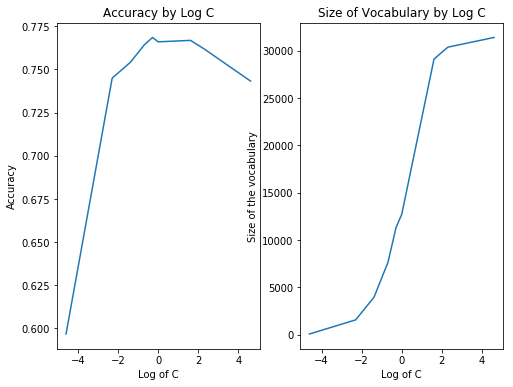

In [20]:
def mostEffectiveFeatures():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    
    countVector = CountVectorizer()
    X = countVector.fit_transform(train_data)
    features = countVector.get_feature_names()
    numFeatures = len(features)

    def runLR(data, regularization = "l2", c=1):
        if regularization == "l1":
            classifier = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', penalty='l1', tol=.01, C=c)
        else:
            classifier = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial', C=c)

        classifier.fit(data, train_labels)
        return classifier

    def getNonZeroWeights(classifier):
        weights = classifier.coef_
        return np.sum(weights!=0)
    
    def getAccuracy(c):
        l1Classifier = runLR(X, 'l1', c)
        vocab = [features[x] for x in range(numFeatures) if sum(l1Classifier.coef_[:,x]) !=0]
        l2CountVector = CountVectorizer(vocabulary=vocab)
        trainData = l2CountVector.fit_transform(train_data)
        devData = l2CountVector.transform(dev_data)
        
        l2Classifier = runLR(trainData, 'l2', c)
        yPredict= l2Classifier.predict(devData)
        accuracy = metrics.accuracy_score(dev_labels, yPredict)
        return accuracy, len(vocab)
    
    l1classifier = runLR(X, 'l1')
    l2classifier = runLR(X, 'l2')
    
#compare non zero weights between l1 vs l2
    nonZeroL1 = getNonZeroWeights(l1classifier)
    nonZeroL2 = getNonZeroWeights(l2classifier)
    print('When C = 1, L1 regularization has', nonZeroL1, 'non zero weights. While L2 regularization has', nonZeroL2, 'non zero weights.')
    
#getting accuracies for different Cs

    Cs = [.01, .1, .25, .5, .75, 1, 5, 10, 100]
    acc = np.empty((0))
    lenVocabByC = np.empty((0))
    for c in Cs:
        accuracy, lenVocab = getAccuracy(c)
        acc = np.append(acc, accuracy)
        lenVocabByC = np.append(lenVocabByC, lenVocab)
    
    plt.figure(figsize=(8, 6))
    
    ax=plt.subplot2grid((1,2), (0,0))
    ax.plot(np.log(Cs), acc)
    ax.set_xlabel("Log of C")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by Log C")

    ax=plt.subplot2grid((1,2), (0,1))
    ax.plot(np.log(Cs), lenVocabByC)
    ax.set_xlabel("Log of C")
    ax.set_ylabel("Size of the vocabulary")
    ax.set_title("Size of Vocabulary by Log C")
    

    
mostEffectiveFeatures()

### Using TfidfVectorizer

CountVectorizer provides a count of number of times a word appears in a given input. On the other hand, TfidfVectorizer counts the occurences of each word in the input as well but it normalizes the count based on how frequent the word is across samples. This reduces weight on common words that appear very frequently across samples and are not very helpful in classification.

In addition to using Tdidf, we will see some of the mistakes that the model makes. For this, we will find documents where the ratio R is largest, where R is maximum predicted probability / predicted probability of the correct label.

In [21]:
def mistakes():
    
    def printSamples(indexes):
        for i in indexes:
            print("Correct Label :", newsgroups_train.target_names[dev_labels[i]])
            print("Predicted Label:", newsgroups_train.target_names[y_predict[i]])
            print("Text :")
            print(dev_data[i])
            print("------------------------------------------------------------------")
            print()
            print()
        
    countVector = TfidfVectorizer()
    X = countVector.fit_transform(train_data)
    XDev = countVector.transform(dev_data)

    classifier = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial', C=100)
    classifier.fit(X, train_labels)
    
    y_predict = classifier.predict(XDev)
    
    pp = classifier.predict_proba(XDev)
    mpp = np.max(pp, axis=1)
    
    i=0
    ppocl = np.empty((0))
    for j in dev_labels:
        ppocl = np.append(ppocl, pp[i,j])
        i+=1

    R = np.divide(mpp, ppocl)
    
    top3 = np.argpartition(R, range(-3,0))[-3:]
    
    printSamples(top3)
    

mistakes()

Correct Label : rec.sport.baseball
Predicted Label: rec.sport.hockey
Text :


In fact, he's a complete and total dickhead on at least 2 newsgroups
(this one and rec.sport.hockey).  Since hockey season is almost over,
he's back to being a dickhead in r.s.bb.

------------------------------------------------------------------


Correct Label : rec.autos
Predicted Label: rec.motorcycles
Text :
best way to reduce risk when operating a vehicle is being able to avoid
hazards and, for that reason my preferred vehicle is a motorcycle.  When I do
use a four wheeler my primary reasons are: it will keep me dry, it will keep
me warm, or it will carry more cargo.  If the four wheeler has as much
collision protection as the average motorcycle, then it has enough form me.

How do you define safe?  One definition of safe is without risk.  Is


-- 
Chas                         DoD #7769
------------------------------------------------------------------


Correct Label : rec.autos
Predicted Label: misc.

**Key takeaways**

Looking at mistakes in the classification, seems like confusion is inherent in the text. For example, if someone is comparing motorbikes and autos, it may be tricky to correctly predict which of the 2 groups did the writer submitted their post to. This limited is expected in a 'bag of words' model which predicts based on words and ignores their order.

**Ideas to improve performance**  

* Include sequence of words instead of just a single word. In fact, given top features seen in P4, the top features don't seem all that relevant and hence maybe the classification should be done entirely based on combination of words.
* Preprocess data similar to P5.
* Choose a appropriate regularization to improve how the model generalizes to unseen data.

### Putting it all together

Picking the most promisng options we have seen so far to see how good a classifer we can build.

In [22]:
def betterPreprocessor(s):

    newS = s
    
    #convert to lowercase
    newS = newS.lower() 
    
    # remove common words
    #list of stopwords from NTLK
    stopWords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself',
                 'yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself',
                 'they','them','their','theirs','themselves','what','which','who','whom','this','that','these',
                 'those','am','is','are','was','were','be','been','being','have','has','had','having','do',
                 'does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of',
                 'at','by','for','with','about','against','between','into','through','during','before','after',
                 'above','below','to','from','up','down','in','out','on','off','over','under','again','further',
                 'then','once','here','there','when','where','why','how','all','any','both','each','few','more',
                 'most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s',
                 't','can','will','just','don','should','now']

    
    for word in stopWords:
        newS = re.sub(r'\b'+word+r'\b', '', newS)
    
#simple stemming
    newS = re.sub(r's\b', '', newS)
    newS = re.sub(r'es\b', '', newS)
    newS = re.sub(r'ies\b', '', newS)

#replace numbers by string 'num'
    newS = re.sub('\d+','num', newS) 

#replace numbers by string 'num'
    newS = re.sub('\d+','num', newS) 

#remove special characters
    newS = re.sub('(\\W|\\d)',' ',newS)

    return newS


def allTogether():
    
    def runLR(ngram_range, analyzer = 'word'):
        countVector = TfidfVectorizer(ngram_range=ngram_range, analyzer = analyzer, preprocessor=betterPreprocessor, min_df=10)
        X = countVector.fit_transform(train_data)
        XDev = countVector.transform(dev_data) 

        Cs = {'C': [1, 10, 100]}
        classifier = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial')
        grid = GridSearchCV(classifier, Cs, cv=5, scoring='f1_micro', n_jobs=-1)
        trained_classifier = grid.fit(X, train_labels)
        y_predict = grid.predict(XDev)
        f1=metrics.f1_score(dev_labels, y_predict, average='micro')
        key = [*grid.best_params_][0]
        print(ngram_range, ':')
        print('Best fit is found when',key, '=', grid.best_params_.get(key))
        print('F1 with dev data of this model is ', round(f1, 4))
        print()
    
    ngrams = [(1,2), (1,3)]
    for ngram in ngrams:
        runLR(ngram)
        
allTogether()

(1, 2) :
Best fit is found when C = 1
F1 with dev data of this model is  0.8283

(1, 3) :
Best fit is found when C = 1
F1 with dev data of this model is  0.8333



Essentially by tweaking various handles that we explored in this assignment, some of which are shown in the code above, we are able to improve the performance upto 83. using combination of :  
1. Data preprocessing to reduce the noise
2. Tfidf Vector instead of simple count vector
3. 1, 2 and 3 word vocabulary instead of single word vocabulary
4. An optimal regularization parameter
